In [1]:
# Import dependencies
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer
from lazypredict.Supervised import LazyClassifier
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

In [2]:
# Import data
path = './Resources/loan.csv'
df = pd.read_csv(path)

# Drop Loan_ID column
df = df.drop(columns='Loan_ID')


In [3]:
# Convert categorical columns to numeric using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Convert string values to numeric
def boolean_to_int(val):
    if val in [True]:
        return 1
    elif val in [False]:
        return 0
    return val

df = df.applymap(boolean_to_int)

# Impute NaN values
imputer = SimpleImputer(strategy='mean')
df[:] = imputer.fit_transform(df)

# # Ensure all columns are numeric
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          614 non-null    int64  
 1   CoapplicantIncome        614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Credit_History           614 non-null    float64
 5   Gender_Male              614 non-null    int64  
 6   Married_Yes              614 non-null    int64  
 7   Dependents_1             614 non-null    int64  
 8   Dependents_2             614 non-null    int64  
 9   Dependents_3+            614 non-null    int64  
 10  Education_Not Graduate   614 non-null    int64  
 11  Self_Employed_Yes        614 non-null    int64  
 12  Property_Area_Semiurban  614 non-null    int64  
 13  Property_Area_Urban      614 non-null    int64  
 14  Loan_Status_Y            6

In [4]:
# define target and feature variables
X = df.drop(columns=['Loan_Status_Y'])
y = df['Loan_Status_Y']

# split data into train and test groups
X_Train, X_Test, y_Train, y_Test = train_test_split(X, y, random_state=42, stratify=y)

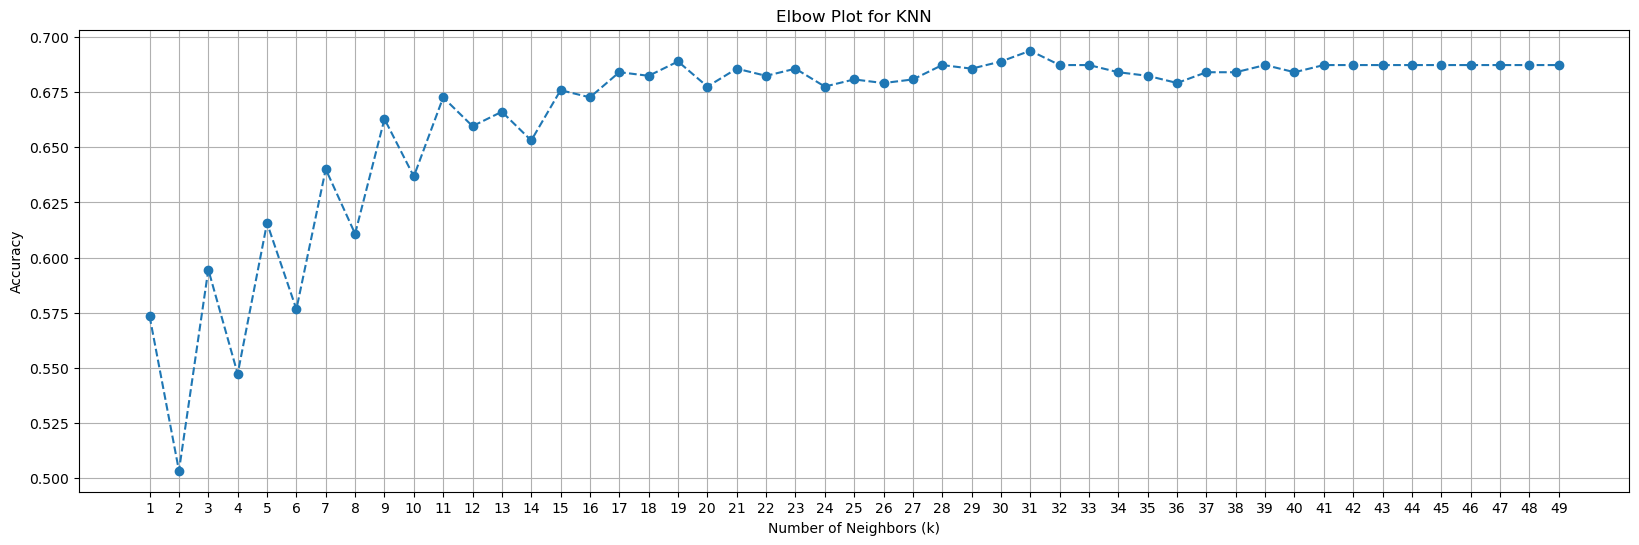

In [5]:
# iterate through data and find best k_value
k_values = list(range(1, 50))
accuracy_scores = []

for i in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn_model, X, y, cv=5)
    accuracy_scores.append(score.mean())

# Plot results to visualize highest accuracy k value
plt.figure(figsize=(20, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='--')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Elbow Plot for KNN')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [6]:
#Train model with best k value
best_k = 19
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_Train, y_Train)

KNeighborsClassifier(n_neighbors=19)

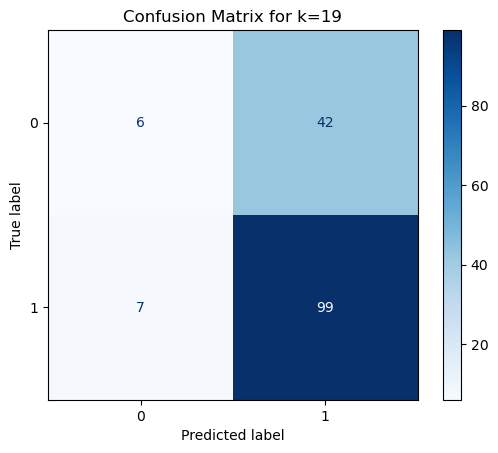

In [8]:
# make predictions
y_pred = knn_model.predict(X_Test)

# evaluate performance with confusion matrix
cm = confusion_matrix(y_Test, y_pred, labels=y_Train.unique()) 

# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_Train.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for k={best_k}')
plt.show()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 25, 'weights': 'uniform'}


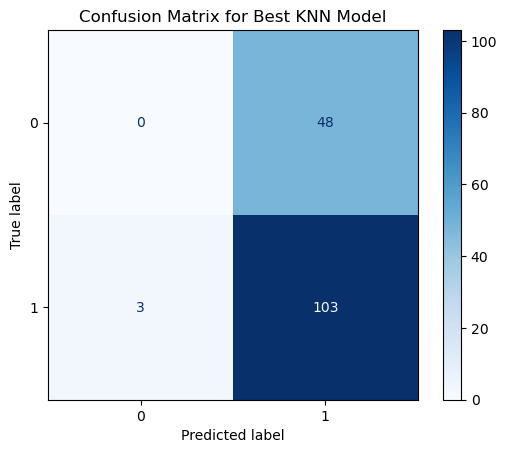

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.68      0.97      0.80       106

    accuracy                           0.67       154
   macro avg       0.34      0.49      0.40       154
weighted avg       0.47      0.67      0.55       154



In [18]:
# Model optimization using grid search

# Define the parameter grid
param_grid = {
    'n_neighbors': range(1, 31),  # Range of k values
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# initiate new model
knn_2 = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_2, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_Train, y_Train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the best model with the best parameters
best_knn = grid_search.best_estimator_

# Make predictions
y_pred = best_knn.predict(X_Test)

# Generate and print the confusion matrix
cm = confusion_matrix(y_Test, y_pred, labels=y_Train.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_Train.unique())
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Best KNN Model')
plt.show()

# Print classification report
print(classification_report(y_Test, y_pred))

In [20]:
# Try LazyClassifier
# Instantiate LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit and evaluate models
models, predictions = clf.fit(X_Train, X_Test, y_Train, y_Test)

# Display the results
print(models)

100%|██████████| 31/31 [00:00<00:00, 38.15it/s]

[LightGBM] [Info] Number of positive: 316, number of negative: 144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686957 -> initscore=0.785929
[LightGBM] [Info] Start training from score 0.785929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 316, number of negative: 144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686957 -> initscore=0.785929
[LightGBM] [Info] Start training from score 0.785929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

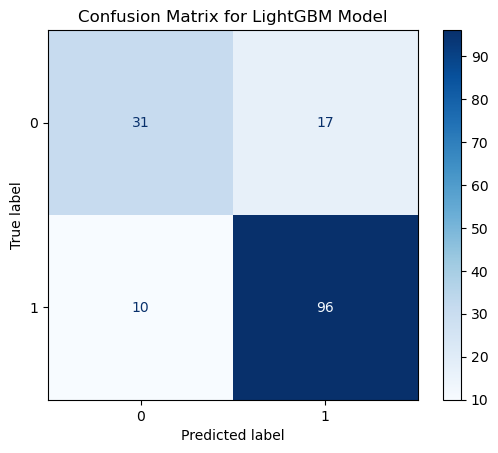

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        48
           1       0.85      0.91      0.88       106

    accuracy                           0.82       154
   macro avg       0.80      0.78      0.79       154
weighted avg       0.82      0.82      0.82       154



In [23]:
# Build LGBClassifier

# Initialize the LightGBM classifier
lgb_model = lgb.LGBMClassifier()

# Train the model
lgb_model.fit(X_Train, y_Train)

# Make predictions
y_pred = lgb_model.predict(X_Test)

# Evaluate the model
accuracy = accuracy_score(y_Test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate and print the confusion matrix
cm = confusion_matrix(y_Test, y_pred)
print('Confusion Matrix:')
print(cm)

# Visualize the confusion matrix
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LightGBM Model')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_Test, y_pred))
